In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import pacf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import keras
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from statsmodels.tsa.stattools import pacf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import warnings
warnings.filterwarnings('ignore')

# 📒  1. Load Google Stock Price data

In [2]:
dataset = pd.read_csv('/kaggle/input/stock/Google.csv')
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,Date
0,2.490664,2.591785,2.390042,2.499133,2.499133,897427216,2004-08-19
1,2.515820,2.716817,2.503118,2.697639,2.697639,458857488,2004-08-20
2,2.758411,2.826406,2.716070,2.724787,2.724787,366857939,2004-08-23
3,2.770615,2.779581,2.579581,2.611960,2.611960,306396159,2004-08-24
4,2.614201,2.689918,2.587302,2.640104,2.640104,184645512,2004-08-25


In [3]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4677.000000,4677.000000,4677.000000,4677.000000,4677.000000,4.677000e+03
mean,38.255309,38.656113,37.861995,38.265822,38.265822,1.226090e+08
std,35.540477,35.943265,35.161971,35.555944,35.555944,1.529406e+08
min,2.470490,2.534002,2.390042,2.490913,2.490913,1.584340e+05
25%,12.657307,12.771629,12.487195,12.640869,12.640869,2.968400e+07
50%,25.577278,25.772150,25.253166,25.534290,25.534290,6.698614e+07
75%,54.528500,55.233501,53.894001,54.546501,54.546501,1.527946e+08
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.650833e+09


# 📊 2. EDA on Google Stock Data

## Checking for any null values present in the dataset

In [4]:
dataset.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Date         0
dtype: int64

## Plotting Few price data

In [5]:
start_date = pd.to_datetime(dataset.Date[0])
end_date = pd.to_datetime(dataset.Date.values[-1])
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [6]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume,Date
4672,90.565002,93.080002,89.940002,91.660004,91.660004,31508600,2023-03-13
4673,93.070000,94.830002,92.779999,94.250000,94.250000,32303900,2023-03-14
4674,93.540001,97.250000,93.040001,96.550003,96.550003,38367300,2023-03-15
4675,96.570000,101.970001,95.870003,101.070000,101.070000,54499500,2023-03-16
4676,100.839996,103.489998,100.750000,102.459999,102.459999,76109100,2023-03-17


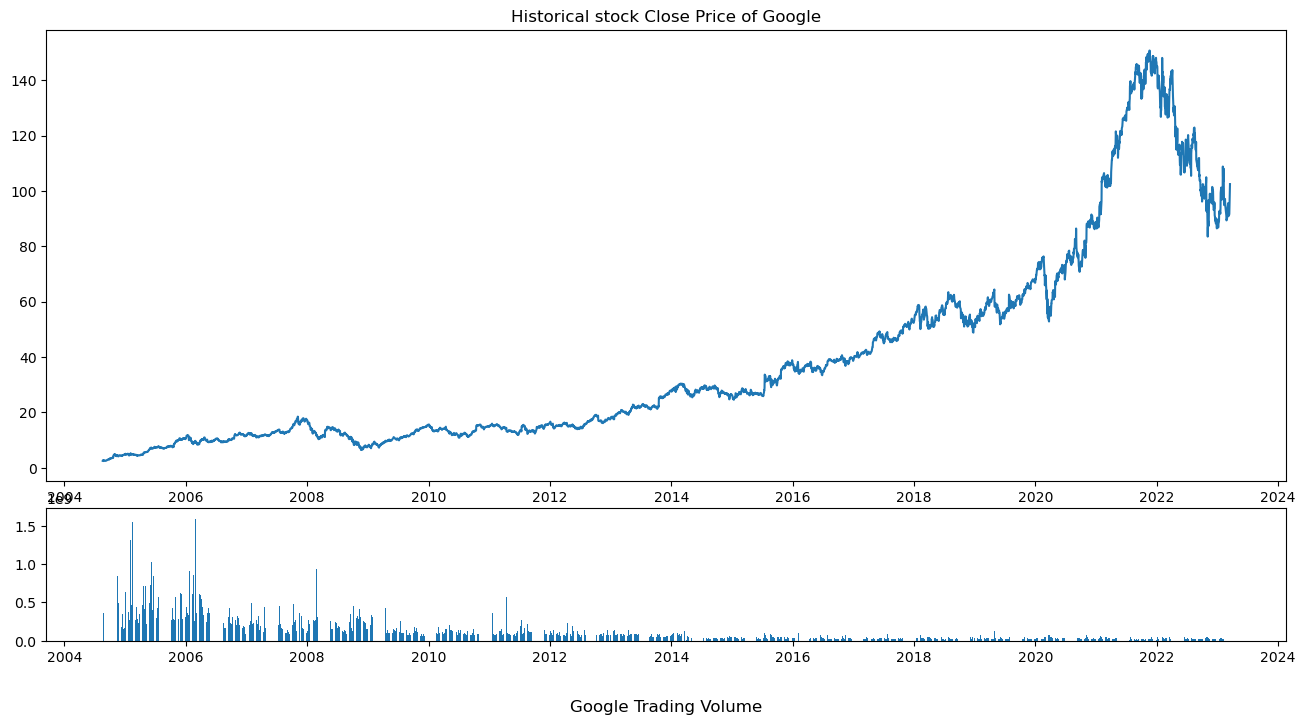

In [7]:
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan = 3, colspan = 4)
top_plt.plot(dataset.Date, dataset["Close"])
plt.title('Historical stock Close Price of Google')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan = 1, colspan = 4)
bottom_plt.bar(dataset.Date, dataset['Volume'])
plt.title('\nGoogle Trading Volume', y = -0.60)
plt.gcf().set_size_inches(16,10)

In [8]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4677.000000,4677.000000,4677.000000,4677.000000,4677.000000,4.677000e+03
mean,38.255309,38.656113,37.861995,38.265822,38.265822,1.226090e+08
std,35.540477,35.943265,35.161971,35.555944,35.555944,1.529406e+08
min,2.470490,2.534002,2.390042,2.490913,2.490913,1.584340e+05
25%,12.657307,12.771629,12.487195,12.640869,12.640869,2.968400e+07
50%,25.577278,25.772150,25.253166,25.534290,25.534290,6.698614e+07
75%,54.528500,55.233501,53.894001,54.546501,54.546501,1.527946e+08
max,151.863495,152.100006,149.887497,150.709000,150.709000,1.650833e+09


## Checking for Correlation

<AxesSubplot:>

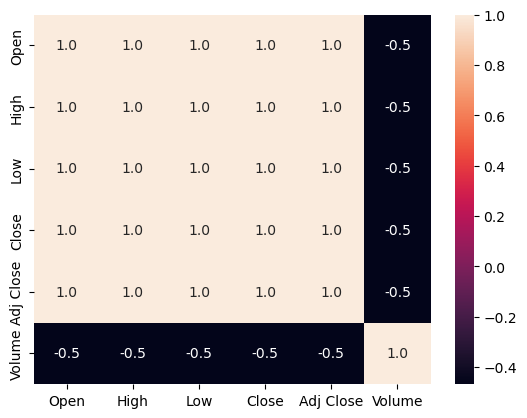

In [9]:
# plotting correlation heatmap
sns.heatmap(dataset.corr(), annot = True, fmt = ".1f")

We go forward with the features : Close and Volume

In [10]:
dataset2 = dataset[['Close', 'Volume']]
dataset2.head()

,Close,Volume
0,2.499133,897427216
1,2.697639,458857488
2,2.724787,366857939
3,2.611960,306396159
4,2.640104,184645512


## Stationarity and detrending (ADF/KPSS)

Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. Many statistical models require the series to be stationary to make effective and precise predictions.

Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test. A method to convert a non-stationary time series into stationary series shall also be used.

## ADF Test

ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:

1. Null Hypothesis: The series has a unit root.
2. Alternate Hypothesis: The series has no unit root.

If the null hypothesis in failed to be rejected, this test may provide evidence that the series is non-stationary.

In [11]:
result = adfuller(dataset2.Close.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 0.013146070658951823
p-value: 0.9596058480724269
Critial Values:
   1%, -3.4317585936404296
Critial Values:
   5%, -2.8621624356024813
Critial Values:
   10%, -2.567101325023956


Conclusion : 

ADF Test Statistic value is greater than all critical values, and p-value is also greater than 0.05.

So we can strongly reject the null hypothesis, and conclude that, Price value is Non-Stationary.


## KPSS test 

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

1. Null Hypothesis: The process is trend stationary.    
2. Alternate Hypothesis: The series has a unit root (series is not stationary).

In [12]:
result = kpss(dataset2['Close'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])

for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}');


KPSS Statistic: 8.705582
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


Conclusion :

Here we find that, KPSS stats value is too high than critical values. 

So, we concluded that this time series is Non-Stationary

# 📙 3. Time Series Prediction

## Models considered : 

  **<span style='color:#2980B9'>ARIMA  </span>**
    
  **<span style='color:#2980B9'>NEURAL NETWORK  </span>**
    
  **<span style='color:#2980B9'>RECURRENT NEURAL NETWORK  </span>**
    
  **<span style='color:#2980B9'>LSTM - LONG SHORT TERM MEMORY  </span>**

## ARIMA - Univariate Price Forecasting

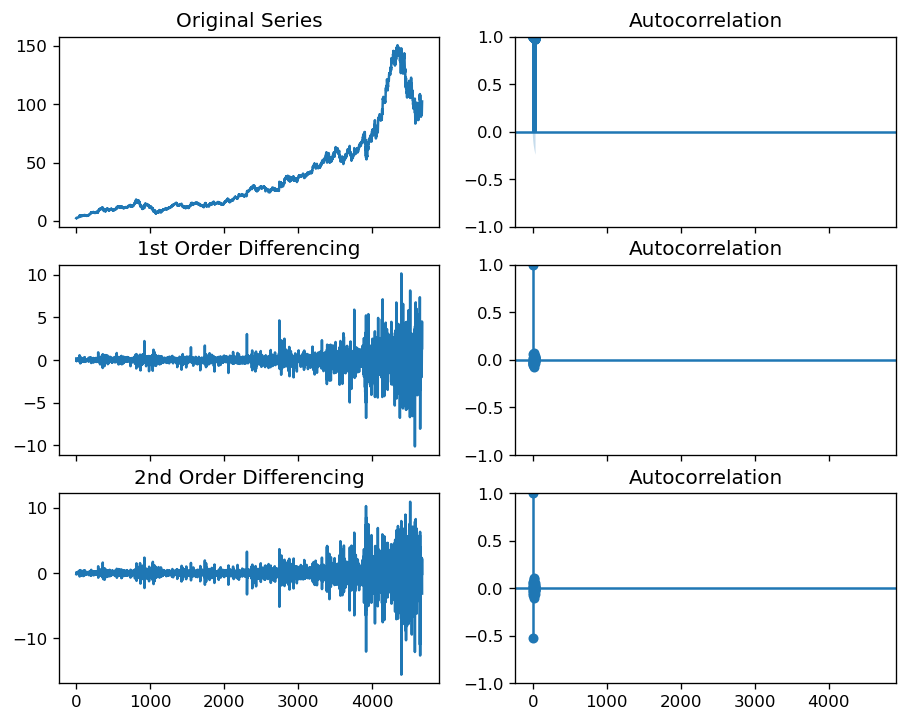

In [13]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(dataset2['Close'].values); axes[0, 0].set_title('Original Series')
plot_acf(dataset2['Close'].values, ax = axes[0, 1])

# 1st Differencing
axes[1, 0].plot(dataset2['Close'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(dataset2['Close'].diff().dropna(), ax = axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(dataset2['Close'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(dataset2['Close'].diff().diff().dropna(), ax = axes[2, 1])

plt.show()

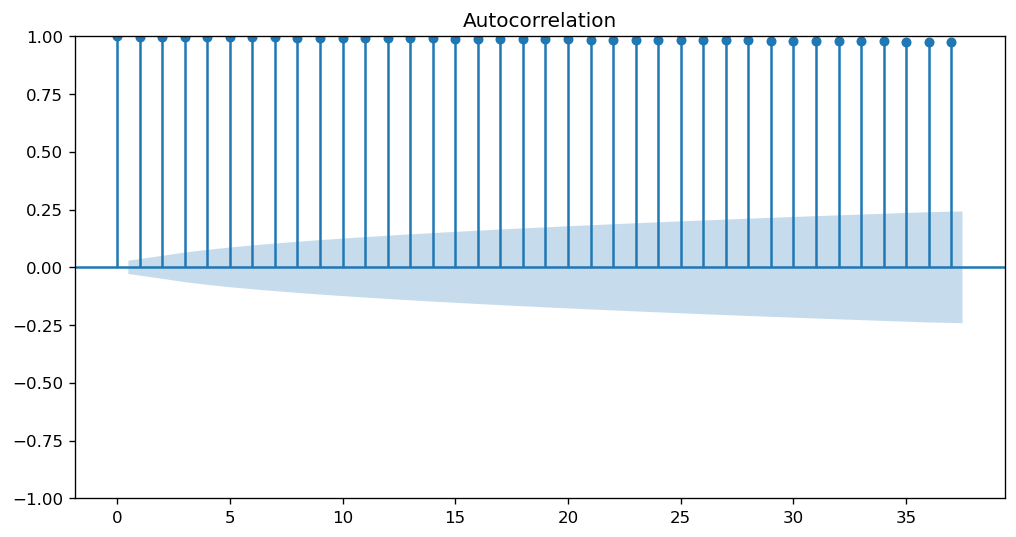

In [14]:
plt.rc("figure", figsize = (10,5))
plot_acf(dataset2['Close'])
print()

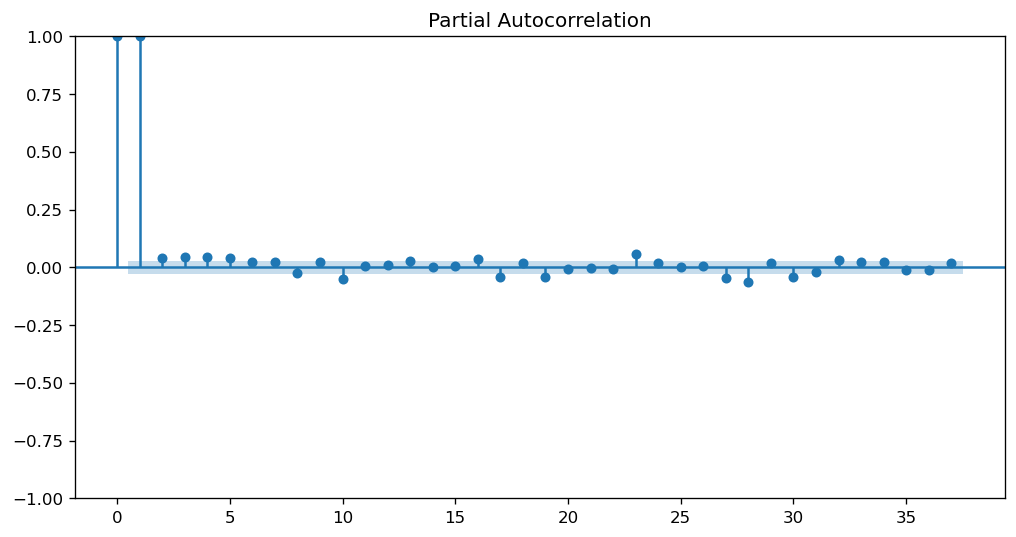

In [15]:
plt.rc("figure", figsize=(10,5))
plot_pacf(dataset2['Close'])
print()

We can observe that the PACF lag 2 is the only one that is quite significant and it is well above the significance line compared to other values. Hence, we can safely set p to 2.

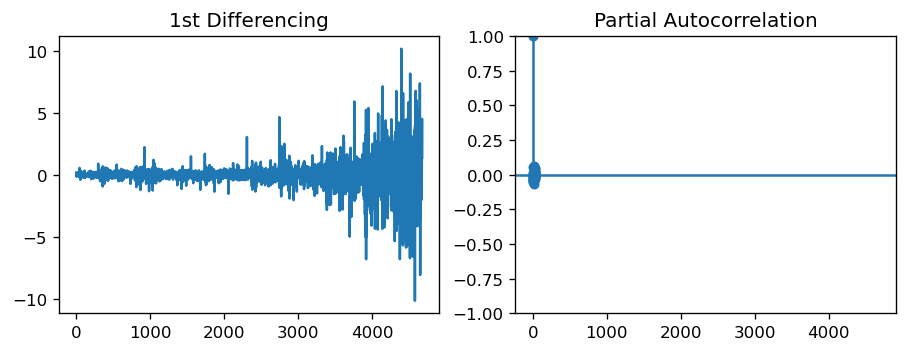

In [16]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(dataset2['Close'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim = (0,5))
plot_pacf(dataset2['Close'].diff().dropna(), ax = axes[1])

plt.show()

### Determining the order of the MA term  

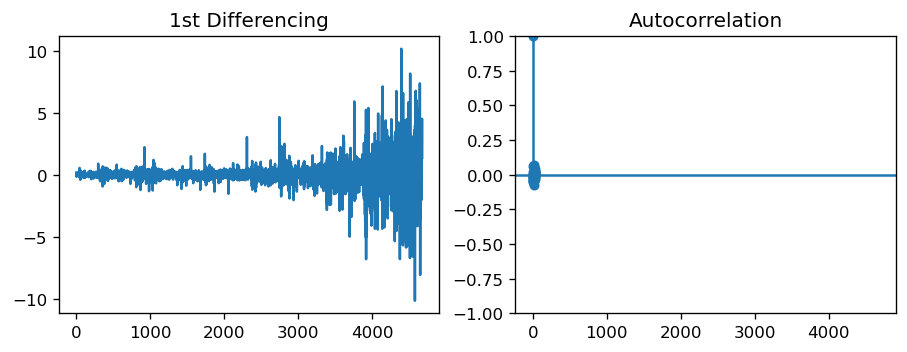

In [17]:
fig, axes = plt.subplots(1, 2, sharex = True)
axes[0].plot(dataset2['Close'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim = (0,1.2))
plot_acf(dataset2['Close'].diff().dropna(), ax=axes[1])

plt.show()

In [18]:
data = dataset2['Close'].values
print('Length of Total data: ', len(data))
train_length = int(len(data) * 0.8)
train_data = data[:train_length]
test_data = data[train_length:]
print('Train and Test data length: ', len(train_data), len(test_data))

Length of Total data:  4677
Train and Test data length:  3741 936


### Building ARIMA Model  

In [19]:
model = ARIMA(train_data, order = (1,0,8))
model_fit = model.fit(low_memory = False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3741
Model:                 ARIMA(1, 0, 8)   Log Likelihood               -2147.440
Date:                Wed, 19 Apr 2023   AIC                           4316.881
Time:                        08:27:32   BIC                           4385.379
Sample:                             0   HQIC                          4341.244
                               - 3741                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.2445     28.105      0.827      0.408     -31.839      78.328
ar.L1          0.9999      0.000   3383.991      0.000       0.999       1.000
ma.L1          0.0232      0.009      2.461      0.0

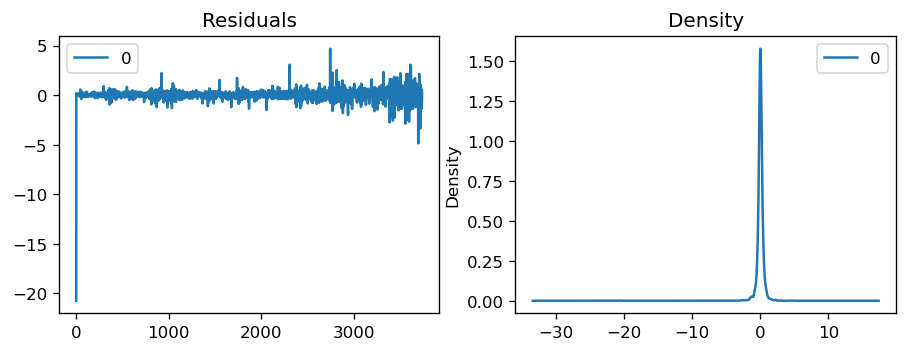

In [20]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title = "Residuals", ax = ax[0])
residuals.plot(kind = 'kde', title = 'Density', ax = ax[1])
plt.show()

In [21]:
# Forecast
forecast_result = model_fit.forecast(150, alpha = 0.05)  # 95% conf
forecast_result[:30]

array([54.07056329, 54.0994797 , 54.124008  , 54.12347112, 54.19426188,
       54.19011658, 54.20672417, 54.18445504, 54.18077934, 54.17710408,
       54.17342926, 54.16975488, 54.16608093, 54.16240742, 54.15873434,
       54.1550617 , 54.1513895 , 54.14771773, 54.1440464 , 54.1403755 ,
       54.13670504, 54.13303502, 54.12936544, 54.12569629, 54.12202757,
       54.11835929, 54.11469145, 54.11102404, 54.10735707, 54.10369053])

In [22]:
test_data[:30]

array([54.89749908, 55.5625    , 56.07899857, 56.57949829, 55.81750107,
       56.24150085, 57.02399826, 57.21049881, 57.24499893, 57.51699829,
       57.67900085, 57.31750107, 57.31650162, 56.50500107, 56.9034996 ,
       57.3105011 , 56.89049911, 56.60599899, 62.52050018, 61.97050095,
       61.25699997, 60.83399963, 60.45050049, 59.69950104, 57.61600113,
       58.49750137, 58.69950104, 60.24000168, 59.40050125, 58.73550034])

### Plotting Test and Predicted Results  

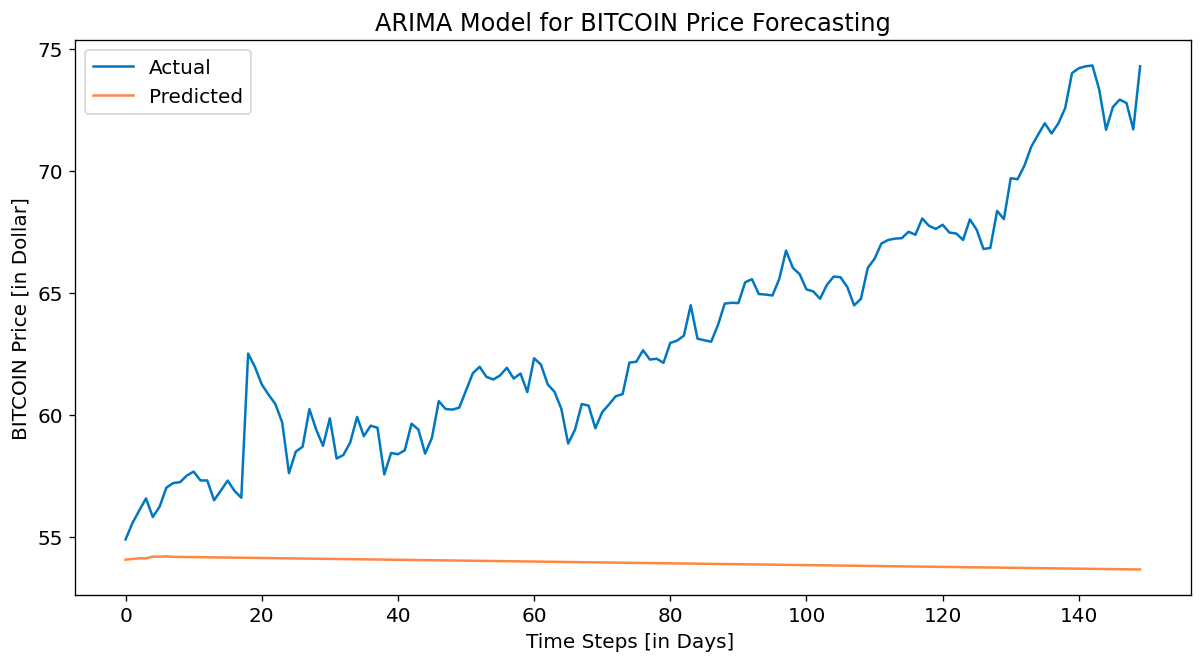

In [23]:
# Here we're plotting Test and Predicted data

plt.figure(figsize = (12, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(test_data[:150], '#0077be',label = 'Actual')
plt.plot(forecast_result[:], '#ff8841',label = 'Predicted')
plt.title('ARIMA Model for BITCOIN Price Forecasting')
plt.ylabel('BITCOIN Price [in Dollar]')
plt.xlabel('Time Steps [in Days] ')
plt.legend()
plt.show()

## Artificial Neural Network 

In [24]:
data = dataset2['Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (4677,)


In [25]:
# Separating train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Train length:  3741
Shape of Train and Test data:  (3741,) (936,)


Changing dataset shape to 2D

In [26]:
train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)
print('Shape of Train and Test data: ', train_data.shape, test_data.shape)

Shape of Train and Test data:  (3741, 1) (936, 1)


In [27]:
def create_dataset(dataset, lookback):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookback -1):
        a = dataset[i: (i+lookback), 0]
        dataX.append(a)
        b = dataset[i+lookback, 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

### Selecting Lag value from PACF graph

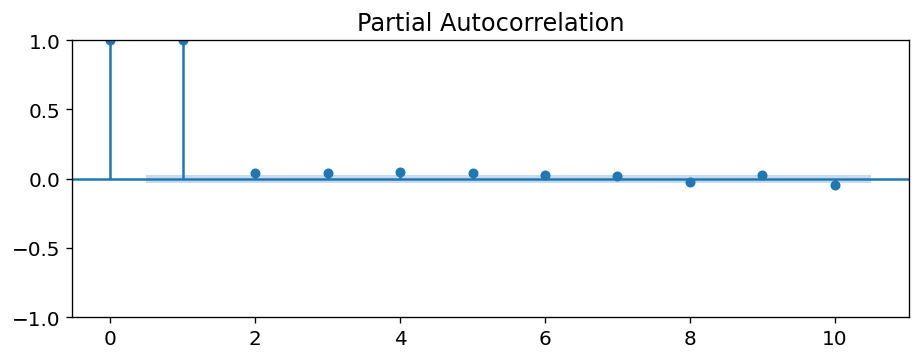

In [28]:
plot_pacf(data, lags = 10)
plt.show()

### Considering only Auto-correlation Lag value Greater than 10%

In [29]:
pacf_value = pacf(data, nlags=20)
lag = 0
# collect lag values greater than 10% correlation 
for x in pacf_value:
    if x > 0.1:
        lag += 1
    else:
        break
print('Selected look_back (or lag = ): ', lag)

Selected look_back (or lag = ):  2


### Separating Input and Output values

In [30]:
train_X, train_y = create_dataset(train_data, lag)
test_X, test_y = create_dataset(test_data, lag)

In [31]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (3738, 2) (3738,)
Shape of test_X and test_y:  (933, 2) (933,)


### Building an MLP model

In [32]:
np.random.seed(7)

In [33]:
model = Sequential()
model.add(Dense(64, input_dim = lag, activation='relu', name= "1st_hidden"))
# model.add(Dense(64, activation='relu', name = '2nd_hidden'))
model.add(Dense(1, name = 'Output_layer', activation = 'linear'))
# model.add(Activation("linear", name = 'Linear_activation'))
model.compile(loss = "mean_squared_error", optimizer = "adam")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 1st_hidden (Dense)          (None, 64)                192       
                                                                 
 Output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 257
Trainable params: 257
Non-trainable params: 0
_________________________________________________________________


### Fitting data to Model

In [34]:
epoch_number = 100
batches = 64

history = model.fit(train_X, train_y, epochs = epoch_number, batch_size = batches, verbose = 1, shuffle = False, 
                    validation_split = 0.1)

Epoch 1/100
53/53 [==============================] - 4s 5ms/step - loss: 24.3662 - val_loss: 3.5901
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3294 - val_loss: 1.2673
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.1652 - val_loss: 1.2163
Epoch 4/100
53/53 [==============================] - 0s 5ms/step - loss: 0.1645 - val_loss: 1.2083
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.1624 - val_loss: 1.2052
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.1608 - val_loss: 1.2058
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.1606 - val_loss: 1.2058
Epoch 8/100
53/53 [==============================] - 0s 3ms/step - loss: 0.1610 - val_loss: 1.2045
Epoch 9/100
53/53 [==============================] - 0s 3ms/step - loss: 0.1619 - val_loss: 1.2025
Epoch 10/100
53/53 [==============================] - 0s 3ms/step - loss: 0.1629 - val_loss: 1.2005
Epoch 11

### Train and Validation Loss

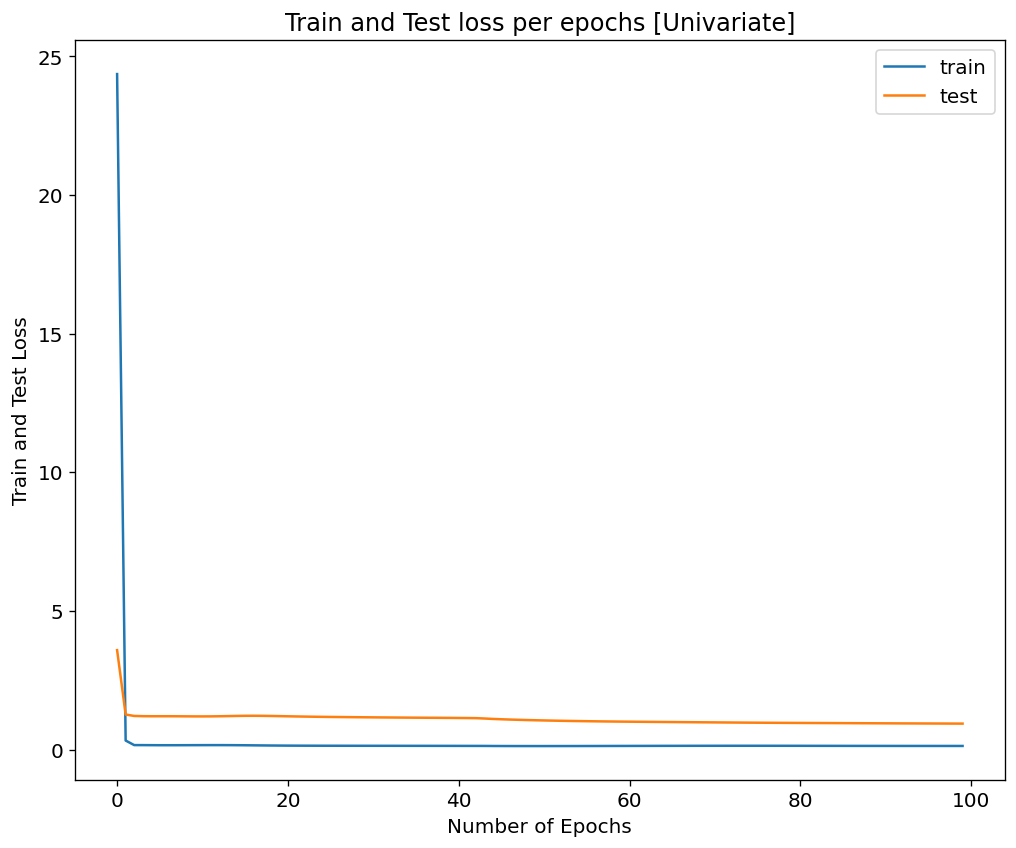

In [35]:
# plot history
plt.clf
plt.figure(figsize = (10,8))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.xlabel('Number of Epochs')
plt.ylabel('Train and Test Loss')
plt.title('Train and Test loss per epochs [Univariate]')
plt.legend()
plt.show()

### Making Predictions

In [36]:
# Make prediction
testPredict = model.predict(test_X)
predicted_value = testPredict[:, 0]

30/30 [==============================] - 0s 2ms/step


### Evaluation Metrics for measuring performance

* **<span style='color:#0A7681'> R-Squared </span>**

* **<span style='color:#0A7681'> Mean Absolute Error </span>**

* **<span style='color:#0A7681'> Mean Absolute Percentage Error</span>**

* **<span style='color:#0A7681'> Mean Squared Error</span>**

* **<span style='color:#0A7681'> Root Mean Squared Error</span>**

* **<span style='color:#0A7681'> Normalized Root Mean Squared Error</span>**

* **<span style='color:#0A7681'> Weighted Absolute Percentage Error</span>**

* **<span style='color:#0A7681'> Weighted Mean Absolute Percentage Error</span>**

In [37]:
def evaluate_forecast_results(actual, predicted):
    print('R2 Score: ', round(r2_score(actual, predicted), 2))
    print('MAE : ', round(mae(actual, predicted), 2))
    print('MSE: ', round(mean_squared_error(actual,predicted), 2))
    print('RMSE: ', round(math.sqrt(mean_squared_error(actual,predicted)), 2))
    print('NRMSE: ', NRMSE(actual, predicted))
    print('WMAPE: ', WMAPE(actual, predicted))
    
def NRMSE(actual, predicted):
    rmse = math.sqrt(mean_squared_error(actual,predicted))
    nrmse = rmse / np.mean(actual)
    return round(nrmse, 4)

def WMAPE(actual, predicted):
    abs_error = np.sum(actual - predicted)
    wmape = abs_error / np.sum(actual)
    return round(wmape, 4)

In [38]:
evaluate_forecast_results(test_y, predicted_value)

R2 Score:  0.99
MAE :  1.48
MSE:  4.27
RMSE:  2.07
NRMSE:  0.021
WMAPE:  0.0029


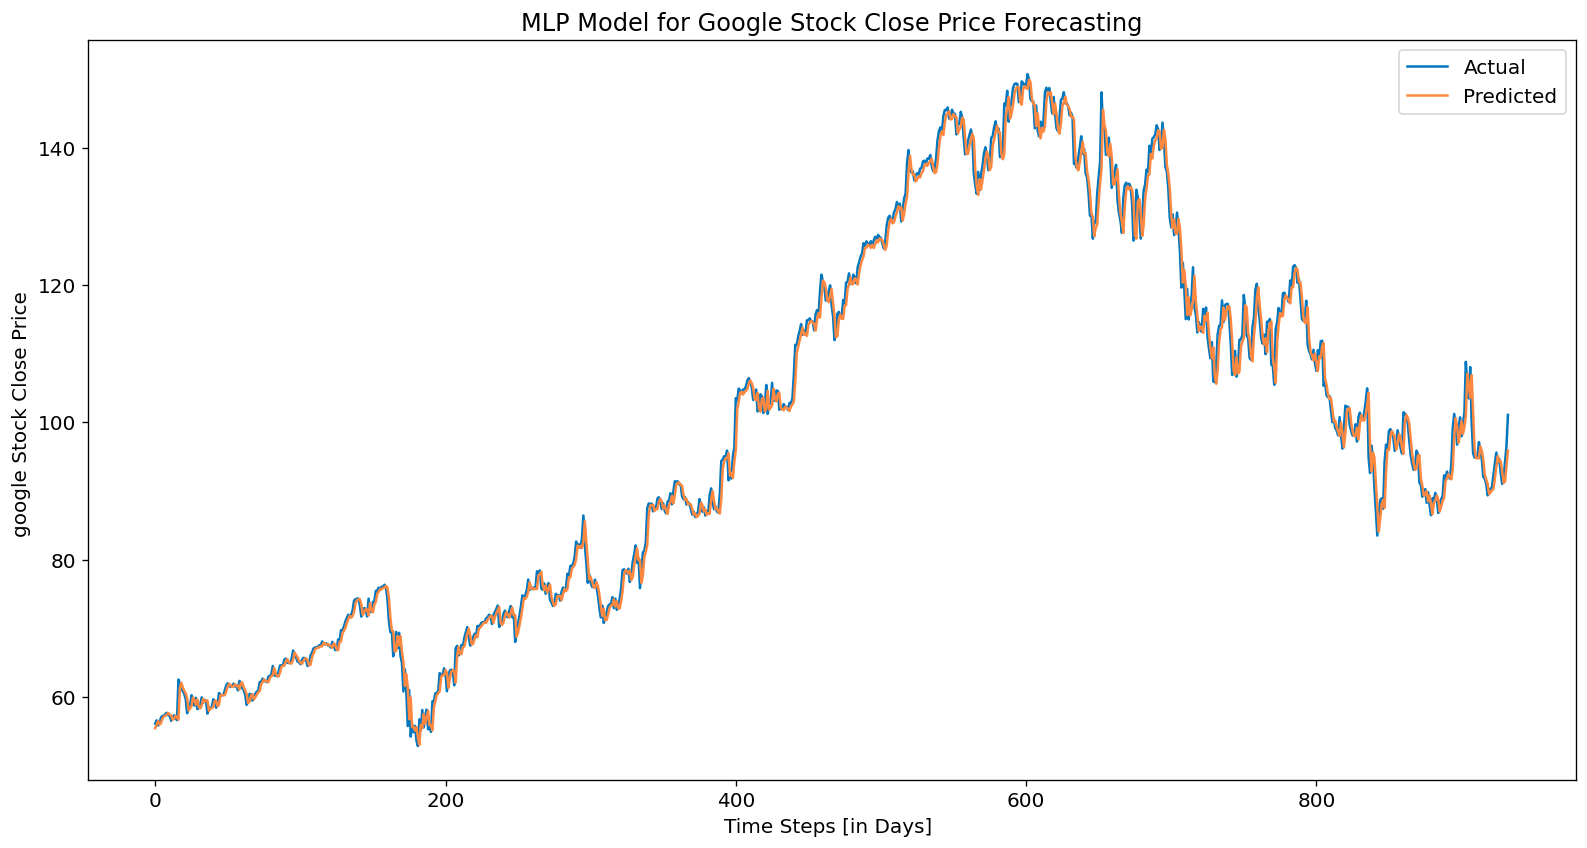

In [39]:
plt.figure(figsize = (16, 8))
plt.rcParams.update({'font.size': 12})
plt.plot(test_y[:], '#0077be', label = 'Actual')
plt.plot(predicted_value, '#ff8841', label = 'Predicted')
plt.title('MLP Model for Google Stock Close Price Forecasting')
plt.ylabel('google Stock Close Price ')
plt.xlabel('Time Steps [in Days] ')
plt.legend()
plt.show()

## RNN - Univariate Time Series Forecasting


In [40]:
data = dataset2['Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (4677,)


In [41]:
# Separate train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)

train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  3741
Shape of Train and Test data:  3741 936


In [42]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Lag Value already to be chosen from PACF Plot

In [43]:
pacf_value = pacf(data, nlags=20)
lag = 0
# collect lag values greater than 10% correlation 
for x in pacf_value:
    if x > 0.1:
        lag += 1
    else:
        break
print('Selected look_back (or lag = ): ', lag)

Selected look_back (or lag = ):  2


In [44]:
n_features = 1

In [45]:
train_X, train_y = split_sequence(train_data, lag)
test_X, test_y = split_sequence(test_data, lag)

In [46]:
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (3739, 2) (3739,)
Shape of test_X and test_y:  (934, 2) (934,)


### Reshaping train_X and test_X to 3-D

In [47]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [48]:
# New shape of train_X and test_X are :-
print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (3739, 2, 1) (3739,)
Shape of test_X and test_y:  (934, 2, 1) (934,)


### Building the model

In [49]:
# define model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', return_sequences = False, input_shape = (lag, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


### Fit the model - with training data

In [50]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [51]:
# fit model
cb = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 15, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs = 150, batch_size = 64, verbose = 1, validation_split = 0.1, 
                   callbacks = [cb])

Epoch 1/150
53/53 [==============================] - 2s 35ms/step - loss: 63.7817 - val_loss: 1.7786
Epoch 2/150
53/53 [==============================] - 2s 32ms/step - loss: 0.2442 - val_loss: 1.3321
Epoch 3/150
53/53 [==============================] - 2s 34ms/step - loss: 0.1646 - val_loss: 1.3236
Epoch 4/150
53/53 [==============================] - 2s 32ms/step - loss: 0.1642 - val_loss: 1.3280
Epoch 5/150
53/53 [==============================] - 2s 38ms/step - loss: 0.1630 - val_loss: 1.3761
Epoch 6/150
53/53 [==============================] - 2s 32ms/step - loss: 0.1631 - val_loss: 1.3353
Epoch 7/150
53/53 [==============================] - 2s 34ms/step - loss: 0.1624 - val_loss: 1.3265
Epoch 8/150
53/53 [==============================] - 2s 32ms/step - loss: 0.1615 - val_loss: 1.3291
Epoch 9/150
53/53 [==============================] - 2s 32ms/step - loss: 0.1608 - val_loss: 1.3206
Epoch 10/150
53/53 [==============================] - 2s 33ms/step - loss: 0.1600 - val_loss: 1.332

### Summarizing model accuracy and Loss

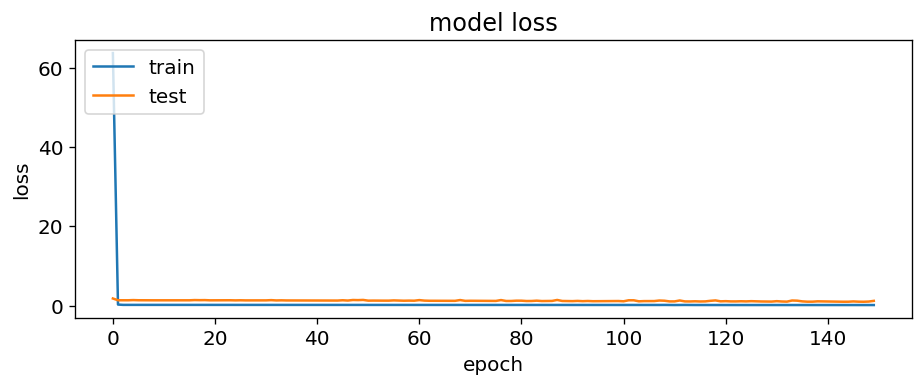

In [52]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Making prediction with Test data

In [53]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

30/30 [==============================] - 0s 9ms/step
Shape of train and test predict:  (3739, 1) (934, 1)


### Model evaluation

In [54]:
actual_ = test_y
predicted_ = test_predict[:, 0]
len(actual_), len(predicted_)

(934, 934)

In [55]:
evaluate_forecast_results(actual_, predicted_)

R2 Score:  0.99
MAE :  1.7
MSE:  5.06
RMSE:  2.25
NRMSE:  0.0228
WMAPE:  0.0092


### Plotting test and predicted data


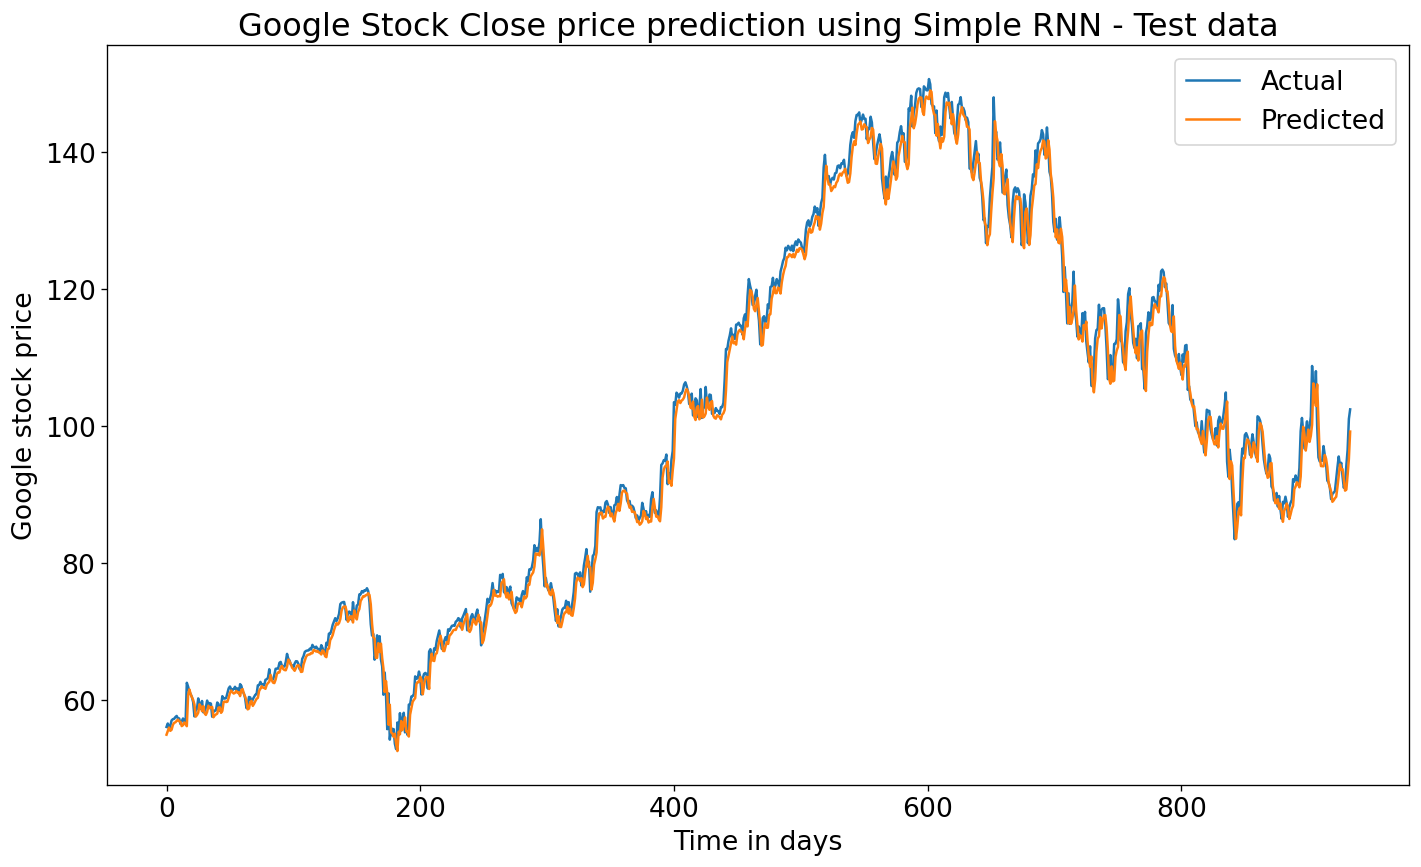

In [56]:
plt.rc("figure", figsize = (14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(actual_, label = 'Actual')
plt.plot(predicted_, label = 'Predicted')
plt.xlabel('Time in days')
plt.ylabel('Google stock price')
plt.title('Google Stock Close price prediction using Simple RNN - Test data')
plt.legend()
plt.show()

In [57]:
df_train = pd.DataFrame(columns = ['Train data'])
df_train['Train data'] = train_data

df = pd.DataFrame(columns = ['Test data', 'Predicted data'])
df['Test data'] = actual_
df['Predicted data'] = predicted_

total_len = len(df_train['Train data']) + len(df['Test data'])
range(len(df_train['Train data']), total_len)
x_list = [x for x in range(len(df_train['Train data']), total_len)]
df.index = x_list

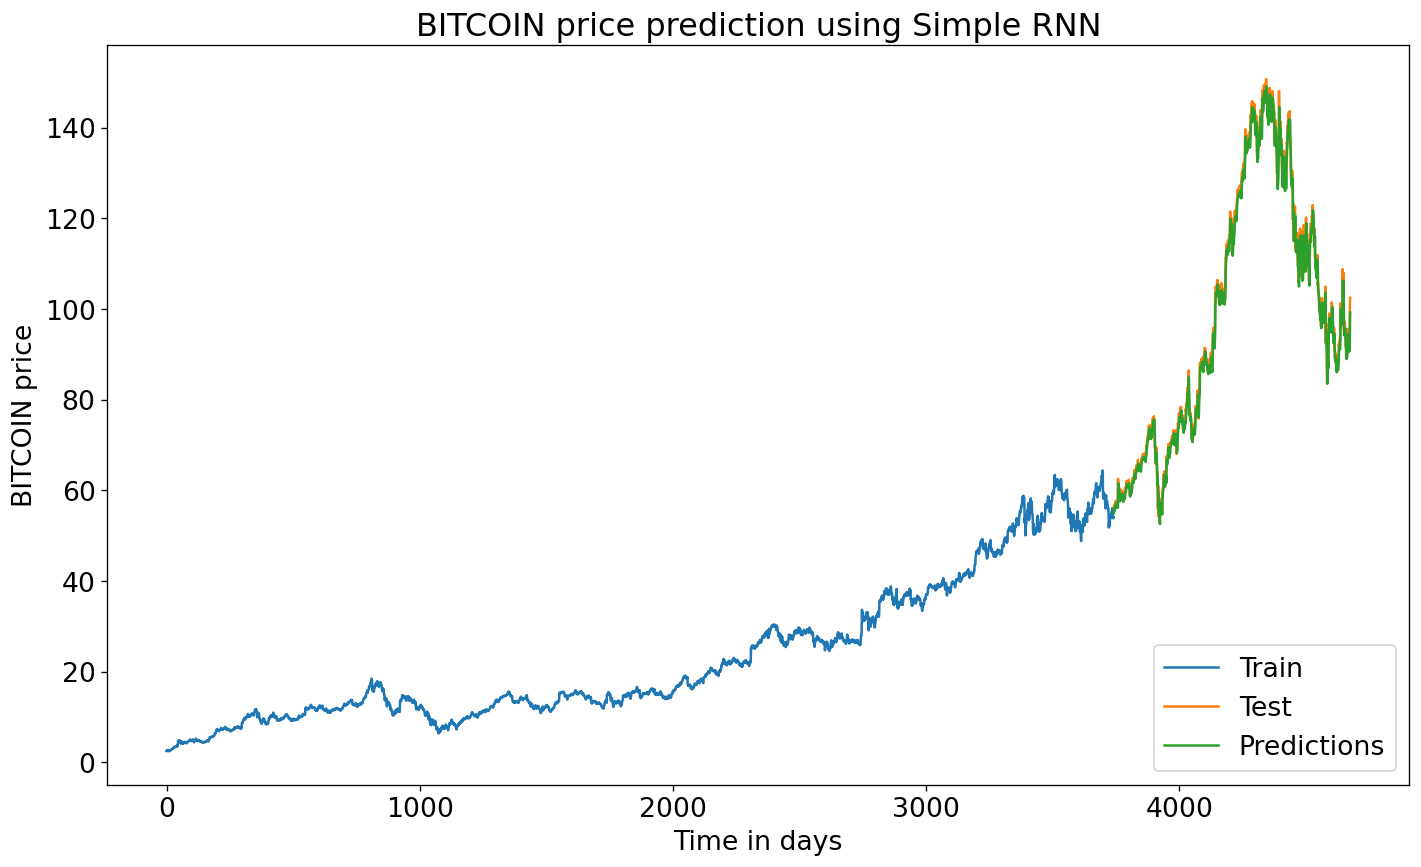

In [58]:
plt.rc("figure", figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.xlabel('Time in days')
plt.ylabel('BITCOIN price')
plt.title('BITCOIN price prediction using Simple RNN')
plt.plot(df_train['Train data'])
plt.plot(df[['Test data', 'Predicted data']])
plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()

##LSTM

In [59]:
data = dataset2['Close'].values
print('Shape of data: ', data.shape)

Shape of data:  (4677,)


In [60]:
# Separate train and test data
train_length = int(len(data) * 0.8)
print('Train length: ', train_length)
train_data, test_data = data[:train_length], data[train_length:]
print('Shape of Train and Test data: ', len(train_data), len(test_data))

Train length:  3741
Shape of Train and Test data:  3741 936


In [61]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Choosing the appropriate lag value

In [62]:
lag = 2  
n_features = 1

In [63]:
train_X, train_y = split_sequence(train_data, lag)
test_X, test_y = split_sequence(test_data, lag)

print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (3739, 2) (3739,)
Shape of test_X and test_y:  (934, 2) (934,)


### Reshaping train_X and test_X to 3D

In [64]:
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

print('Shape of train_X and train_y: ', train_X.shape, train_y.shape)
print('Shape of test_X and test_y: ', test_X.shape, test_y.shape)

Shape of train_X and train_y:  (3739, 2, 1) (3739,)
Shape of test_X and test_y:  (934, 2, 1) (934,)


### Building LSTM Model

In [65]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences = True, input_shape = (lag, n_features)))
model.add(LSTM(64, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


### Fitting model with data

In [66]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [67]:
cb = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 15, restore_best_weights = True)
history = model.fit(train_X, train_y, epochs = 150, batch_size = 64, verbose = 1, validation_split =  0.1, 
                   callbacks = [cb])

Epoch 1/150
53/53 [==============================] - 3s 62ms/step - loss: 278.4522 - val_loss: 4.4139
Epoch 2/150
53/53 [==============================] - 4s 66ms/step - loss: 2.6948 - val_loss: 1.6501
Epoch 3/150
53/53 [==============================] - 3s 57ms/step - loss: 0.5502 - val_loss: 1.7011
Epoch 4/150
53/53 [==============================] - 3s 57ms/step - loss: 0.4111 - val_loss: 1.9431
Epoch 5/150
53/53 [==============================] - 3s 59ms/step - loss: 0.3325 - val_loss: 2.3610
Epoch 6/150
53/53 [==============================] - 3s 59ms/step - loss: 0.2890 - val_loss: 3.0271
Epoch 7/150
53/53 [==============================] - 3s 58ms/step - loss: 0.2626 - val_loss: 2.6862
Epoch 8/150
53/53 [==============================] - 3s 59ms/step - loss: 0.2434 - val_loss: 2.1981
Epoch 9/150
53/53 [==============================] - 3s 61ms/step - loss: 0.2276 - val_loss: 2.2166
Epoch 10/150
53/53 [==============================] - 3s 61ms/step - loss: 0.2157 - val_loss: 2.02

### Summarizing model accuracy and Loss

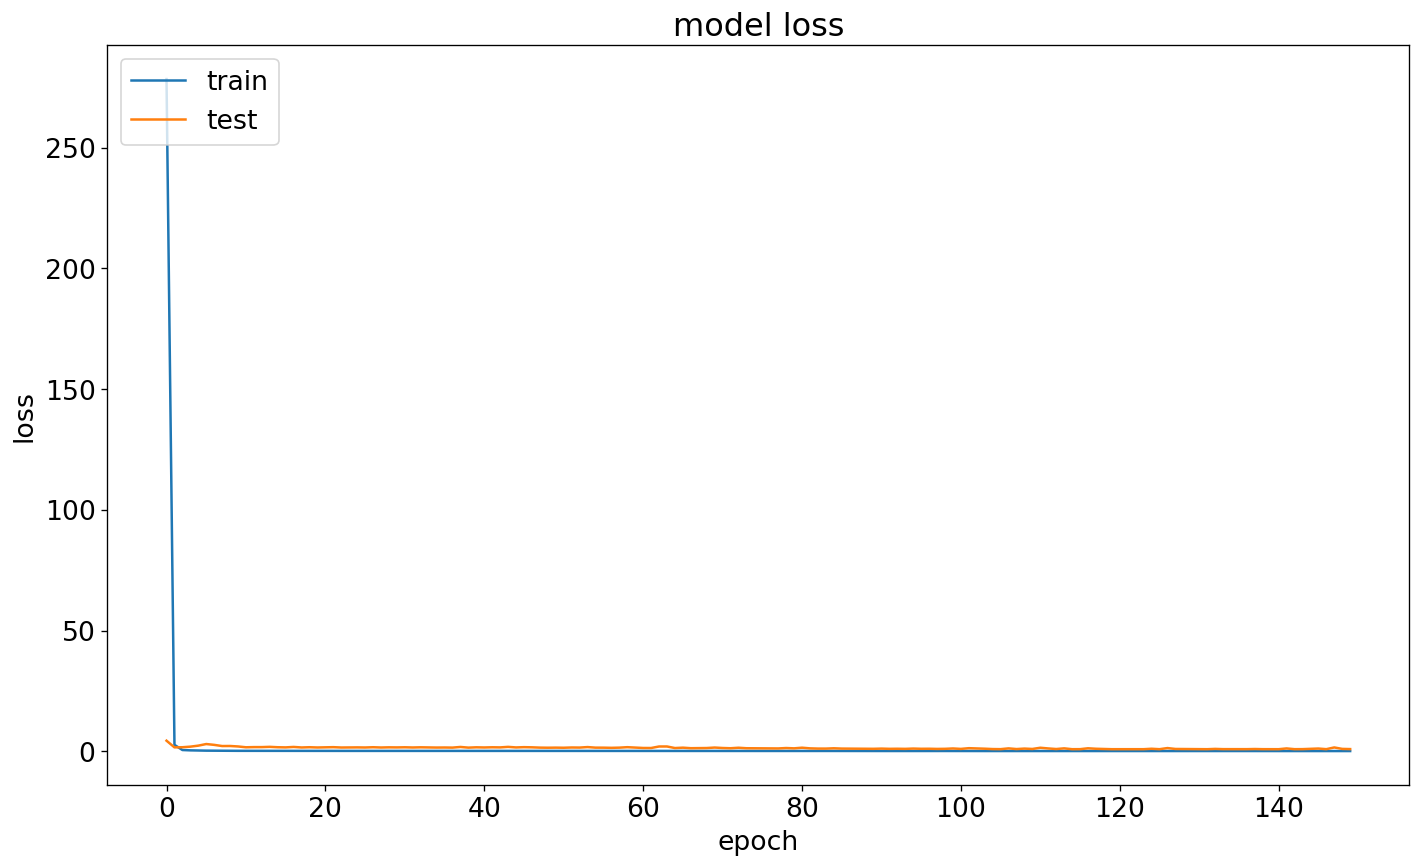

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Making the prediction

In [69]:
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

print('Shape of train and test predict: ', train_predict.shape, test_predict.shape)

30/30 [==============================] - 1s 20ms/step
Shape of train and test predict:  (3739, 1) (934, 1)


### Model Evaluation

In [70]:
actual_lstm = test_y
predicted_lstm = test_predict[:, 0]
evaluate_forecast_results(actual_lstm, predicted_lstm)

R2 Score:  0.99
MAE :  2.45
MSE:  10.28
RMSE:  3.21
NRMSE:  0.0325
WMAPE:  0.0206


In [71]:
df_train = pd.DataFrame(columns = ['Train data'])
df_train['Train data'] = train_data

df = pd.DataFrame(columns = ['Test data', 'Predicted data'])
df['Test data'] = actual_lstm
df['Predicted data'] = predicted_lstm

total_len = len(df_train['Train data']) + len(df['Test data'])
range(len(df_train['Train data']), total_len)
x_list = [x for x in range(len(df_train['Train data']), total_len)]
df.index = x_list

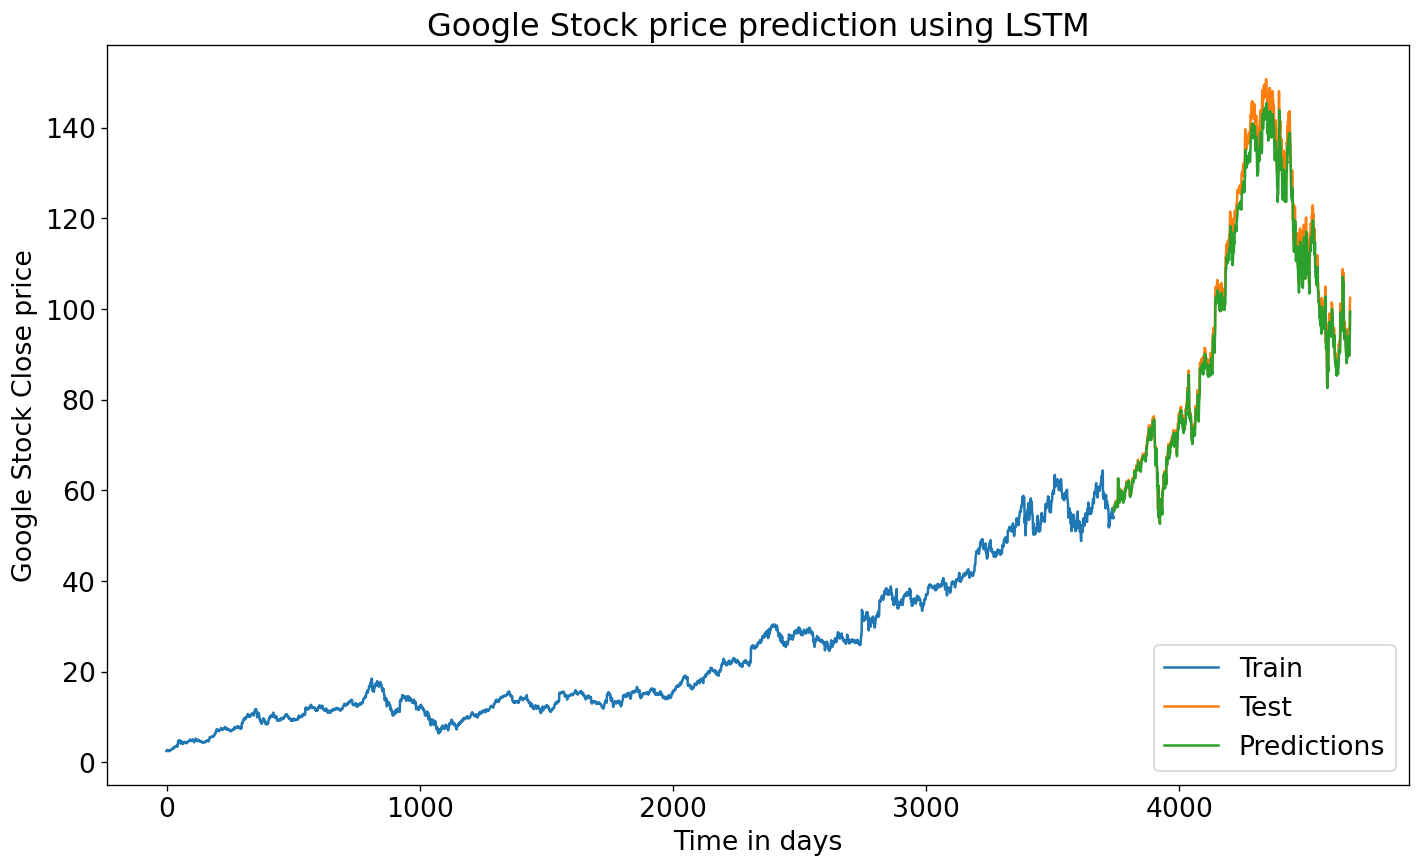

In [72]:
plt.rc("figure", figsize = (14,8))
plt.rcParams.update({'font.size': 16})
plt.xlabel('Time in days')
plt.ylabel('Google Stock Close price')
plt.title('Google Stock price prediction using LSTM')
plt.plot(df_train['Train data'])
plt.plot(df[['Test data', 'Predicted data']])
plt.legend(['Train', 'Test', 'Predictions'], loc = 'lower right')
plt.show()

Thanks for sparing your time! Do upvote if you liked it, This motivates hugely to come up with new explorations and keep exploring new domains.

It would be really nice if you check my other works and if you like my work then don't forget to follow for more interesting notebooks 🤗